In [184]:
import numpy as np
import pandas as pd
from trueskill import TrueSkill

class RatingsInfo:
    elo = None
    wins = None
    losses = None
    def __init__(self, env):
        self.elo = env.create_rating()
        self.wins, self.losses = 0, 0

def get_elo(d, env, player):
    if player not in d: d[player] = RatingsInfo(env)
    return d[player].elo

def calc_elo(df):
    env = TrueSkill(draw_probability=0)
    ratings = {}
    for idx, row in df.iterrows():
        teams = [[get_elo(ratings, env, player) for player in team] for team in row['teams']]
        elos = env.rate(teams, row['ranks'])
        has_winner = sum(row['ranks']) > 0
        for team, team_elos, team_rank in zip(row['teams'], elos, row['ranks']):
            for player, player_elo in zip(team, team_elos):
                ratings[player].elo = player_elo
                if has_winner:
                    if team_rank == 0: ratings[player].wins += 1
                    else: ratings[player].losses += 1
        df.loc[idx, 'elos'] = [elos]
    return ratings, df

def parse_results():
    results = []
    with open('results.txt') as f:
        for line in f.readlines():
            if line.startswith('DATE'): continue
            date, game, teams, ranks = line.split('|')
            teams, ranks = teams.split(';'), ranks.split(';')
            teams = [team.split(',') for team in teams]
            ranks = [int(rank) for rank in ranks]
            results.append((date, game, teams, ranks))

    res_df = pd.DataFrame(results, columns=['date', 'game', 'teams', 'ranks'])

    elos = {}
    for game in res_df.game.unique():
        elos[game] = calc_elo(res_df.loc[res_df.game == game])[0]
    return calc_elo(res_df) + (elos,)  # Tuple concatenation

def update_readme():
    all_ratings, all_df, per_game_ratings = parse_results()

    markdown = '''
## Game Night Rankings
## ![Image](https://media.architecturaldigest.com/photos/618036966ba9675f212cc805/16:9/w_2560%2Cc_limit/SquidGame_Season1_Episode1_00_44_44_16.jpg)'''

    markdown += '''
### Total Rankings

| Player | ELO | Wins | Losses | Win % | Best Game |
| --- | --- | --- | --- | --- |'''

    best_game = {}
    for game, ratings in per_game_ratings.items():
        for player, rating in ratings.items():
            if player not in best_game or rating.elo.mu > best_game[player][1]:
                best_game[player] = (game, rating.elo.mu)

    for player, rating in sorted(all_ratings.items(), key=lambda item: item[1].elo.mu, reverse=True):
        markdown += '''
| {} | {:.2f} | {} | {} | {:.2f} | {} |'''.format(
        player, rating.elo.mu, rating.wins, rating.losses,
        rating.wins / (rating.wins + rating.losses), best_game[player][0])

    chart_df = pd.DataFrame()
    for _, row in all_df.iterrows():
        players = list(np.array(row['teams']).flat)
        ratings = [elo.mu for elo in np.array(row['elos']).flat]
        for player, rating in zip(players, ratings):
            chart_df.loc[row['date'], player] = rating
    chart_df.ffill(inplace=True)
    chart_df.plot.line().legend(loc='lower center', ncol=10, bbox_to_anchor=(0.5, -0.3))
    plt.pyplot.savefig('rankings.png')

    markdown += '''
## ![Image](rankings.png)'''
    
    for game, ratings in per_game_ratings.items():
        markdown += '''
### {}

| Player | ELO | Wins | Losses | Win % |
| --- | --- | --- | --- | --- |'''.format(game)
        for player, rating in sorted(ratings.items(), key=lambda item: item[1].elo.mu, reverse=True):
            markdown += '''
| {} | {}  | {} | {} | {:.2f} |'''.format(
            player, rating.elo.mu, rating.wins, rating.losses,
            rating.wins / (rating.wins + rating.losses))

    with open('README.md', 'w') as f:
        f.write(markdown)
 


/Users/olives/.local/share/virtualenvs/gamenightrankings-1Cza9sBa/lib/python3.8/site-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/Users/olives/.local/share/virtualenvs/gamenightrankings-1Cza9sBa/lib/python3.8/site-packages/pandas/core/indexing.py:1797: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, v, pi)


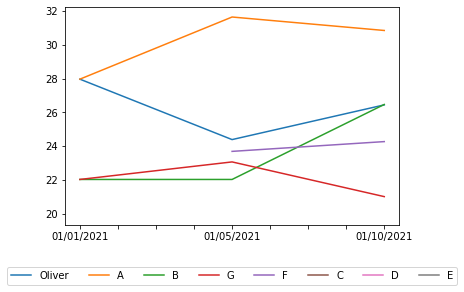

In [185]:
update_readme()